# 03 | Lab Exercise: Implementing and Visualizing Adversarial Examples

Import **Pytorch** libraries and APIs. ss


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from torch.utils.data import Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# define the function of displaying multiple images
def show_images(images) -> None:
    n: int = images.size(0)

    f = plt.figure(figsize=(24, 6))
    for i in range(n):

        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')

    plt.show(block=True)

# define the function of displaying multiple images
def show_images_withPred(images,label,pred) -> None:
    n: int = images.size(0)

    f = plt.figure(figsize=(24, 6))
    for i in range(n):

        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title("{} -> {}".format(label[i], pred[i]))

        #plt.title("Conf:{} \n {} -> {}".format(conf[i][pred[i]]*100,label[i], pred[i]))
        plt.axis('off')

    plt.show(block=True)




Data

In [ ]:
# Hyperparameters and Data loaders
num_epochs = 10
num_classes = 10
batch_size = 256
learning_rate = 0.001


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])


# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)


# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 345kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.21MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.98MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw




/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


#CNN

In [ ]:
# CNN
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(1, -1),
            nn.Linear(7 * 7 * 16, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
        )
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        out = self.features(x)
        out = self.fc3(out)

        return out


model=LeNet()
model.cuda()
model.train()


LeNet(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=784, out_features=120, bias=True)
    (10): ReLU()
    (11): Linear(in_features=120, out_features=84, bias=True)
    (12): ReLU()
  )
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Criterion and Optimizer

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Model Training

In [ ]:

model.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))

Epoch [1/10], Step [0/235], Loss: 2.3207, Accuracy: 10.55%
Epoch [1/10], Step [150/235], Loss: 0.0653, Accuracy: 98.05%
Epoch [2/10], Step [0/235], Loss: 0.0428, Accuracy: 98.83%
Epoch [2/10], Step [150/235], Loss: 0.0205, Accuracy: 99.61%
Epoch [3/10], Step [0/235], Loss: 0.0439, Accuracy: 98.05%
Epoch [3/10], Step [150/235], Loss: 0.0640, Accuracy: 97.27%
Epoch [4/10], Step [0/235], Loss: 0.0090, Accuracy: 100.00%
Epoch [4/10], Step [150/235], Loss: 0.0191, Accuracy: 99.61%
Epoch [5/10], Step [0/235], Loss: 0.0082, Accuracy: 100.00%
Epoch [5/10], Step [150/235], Loss: 0.0213, Accuracy: 99.22%
Epoch [6/10], Step [0/235], Loss: 0.0183, Accuracy: 99.22%
Epoch [6/10], Step [150/235], Loss: 0.0160, Accuracy: 99.22%
Epoch [7/10], Step [0/235], Loss: 0.0082, Accuracy: 100.00%
Epoch [7/10], Step [150/235], Loss: 0.0046, Accuracy: 100.00%
Epoch [8/10], Step [0/235], Loss: 0.0027, Accuracy: 100.00%
Epoch [8/10], Step [150/235], Loss: 0.0017, Accuracy: 100.00%
Epoch [9/10], Step [0/235], Loss: 

#Model Evaluating

In [ ]:
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

Accuracy of the model on the 10000 test images: 98.54 %


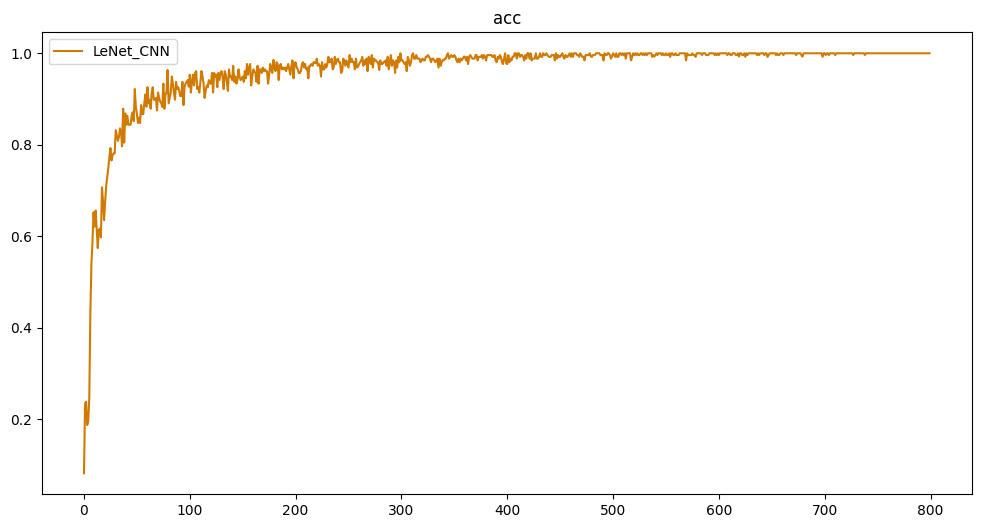

Text(0.5, 1.0, 'loss')

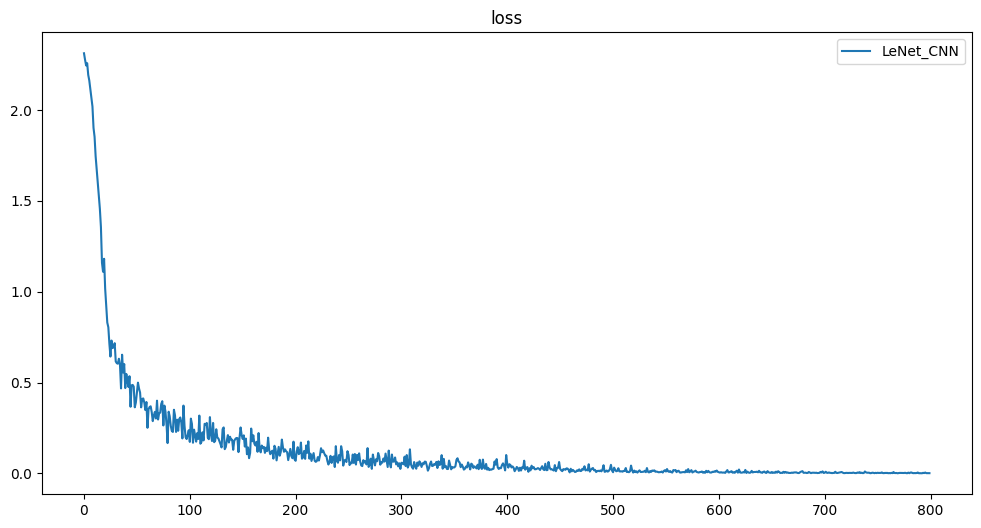

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12, 6))
plt.plot(acc_list_cnn, color='#D17A00')
plt.legend(['LeNet_CNN'])
plt.title('acc')
plt.show()


plt.figure(figsize=(12,6))
plt.plot(loss_list_cnn)
plt.legend(['LeNet_CNN'])
plt.title('loss')

# **Adversarial Examples**





#Random Noise

In [ ]:
#Random noise injection
def rand_noise_attack(images, step_size) :
    rand_perturbation = torch.randn_like(images)
    ae_images = images + step_size*rand_perturbation.sign()
    #show_images(rand_perturbation.sign()[:5])
    ae_images = torch.clamp(ae_images, 0, 1)

    return ae_images

Random Noise Evaluation

Accuracy of the model on the 10000 test images when Random Noise Injection is used: 67.97999999999999 %


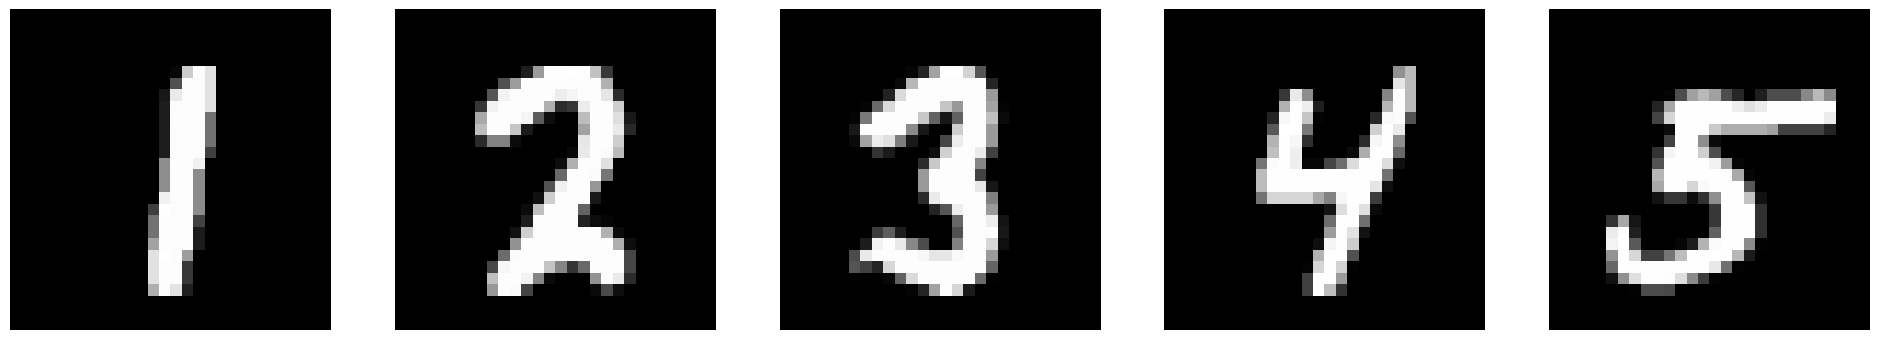

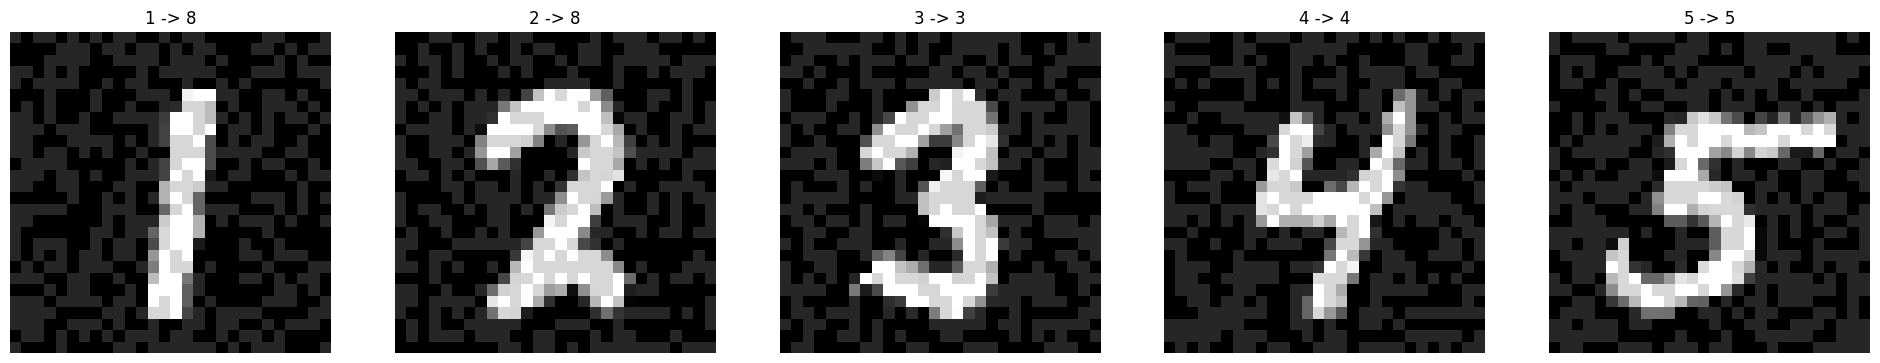

In [ ]:
model.eval()

correct = 0
total = 0
for images, labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()
    ae_images = rand_noise_attack(images,step_size=0.15)

    outputs = model(ae_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the 10000 test images when Random Noise Injection is used: {} %'.format((correct / total) * 100))

F

show_images(images[:5].detach())
show_images_withPred(ae_images[:5].detach(),labels[:5], outputs[:5].argmax(dim=1))

#FGSM

In [ ]:
#FGSM
def fgsm(model, criterion, images, labels, step_size) :

    images.requires_grad = True

    outputs = model(images)

    model.zero_grad()
    loss = criterion(outputs, labels)
    loss.backward()

    ae_images = images + step_size*images.grad.sign()
    ae_images = torch.clamp(ae_images, 0, 1)

    return ae_images

FGSM Evaluation

Accuracy of the model on the 10000 test images when FGSM is used: 24.0 %


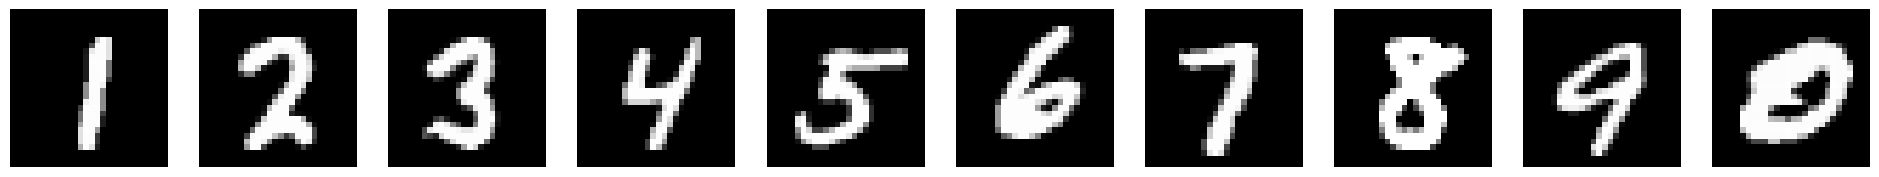

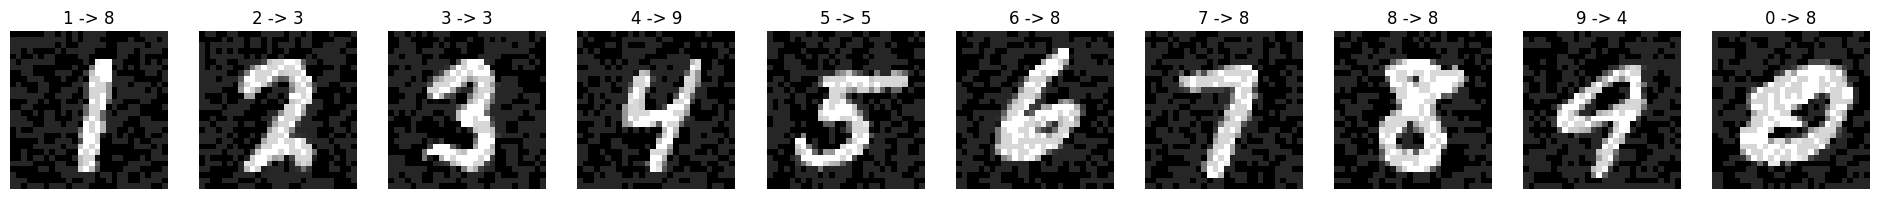

In [ ]:
model.eval()

correct = 0
total = 0
for images, labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()
    ae_images = fgsm(model, criterion, images, labels, step_size=0.15)

    outputs = model(ae_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the 10000 test images when FGSM is used: {} %'.format((correct / total) * 100))


show_images(images[:10].detach())
# show_images(ae_images[:10].detach())
show_images_withPred(ae_images[:10].detach(),labels[:10], outputs[:10].argmax(dim=1))

Changed perturbation magnitude

Accuracy of the model on the 10000 test images when FGSM is used: 17.69 %


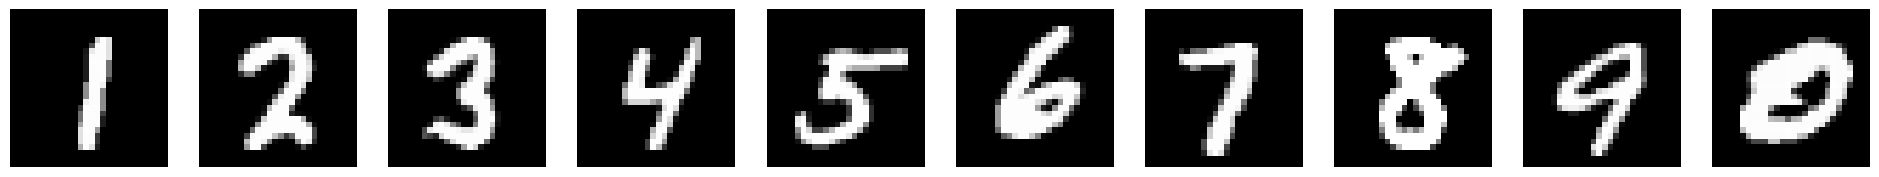

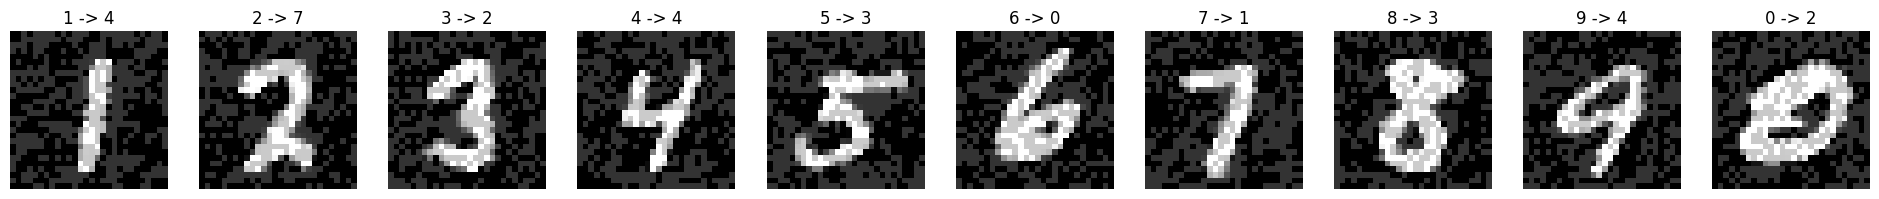

In [ ]:
model.eval()

correct = 0
total = 0
for images, labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()
    ae_images = fgsm(model, criterion, images, labels, step_size=0.2)

    outputs = model(ae_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the 10000 test images when FGSM is used: {} %'.format((correct / total) * 100))


show_images(images[:10].detach())
# show_images(ae_images[:10].detach())
show_images_withPred(ae_images[:10].detach(),labels[:10], outputs[:10].argmax(dim=1))

Accuracy of the model on the 10000 test images when FGSM is used: 9.790000000000001 %


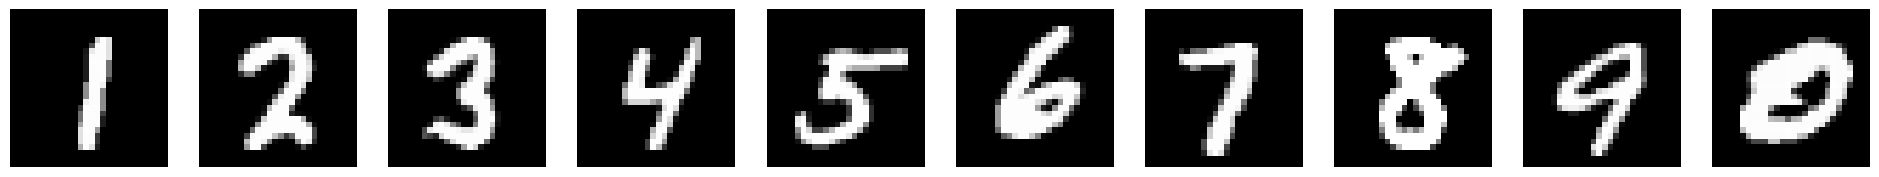

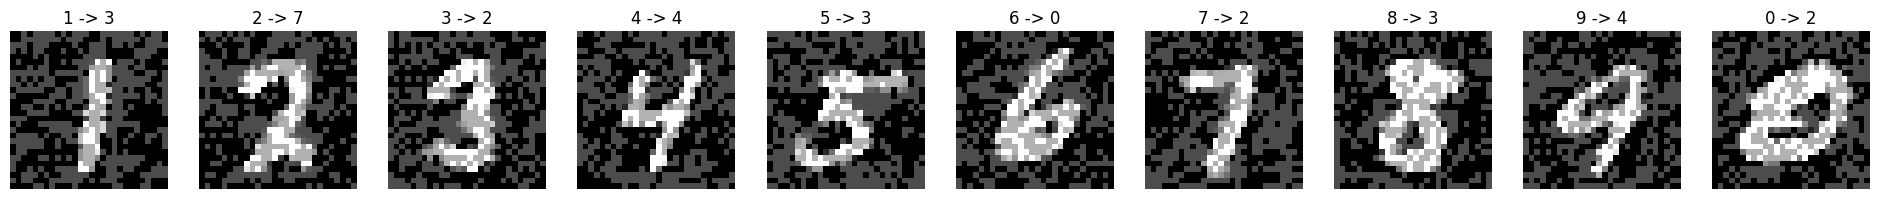

In [ ]:
model.eval()

correct = 0
total = 0
for images, labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()
    ae_images = fgsm(model, criterion, images, labels, step_size=0.3)

    outputs = model(ae_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the 10000 test images when FGSM is used: {} %'.format((correct / total) * 100))


show_images(images[:10].detach())
# show_images(ae_images[:10].detach())
show_images_withPred(ae_images[:10].detach(),labels[:10], outputs[:10].argmax(dim=1))

#PGD

In [ ]:
# PGD Attack

def pgd_attack(model, images, criterion, labels, eps=0.3, step_size=0.004, iters=40) :
    images = images.cuda()
    labels = labels.cuda()

    ori_images = images.data

    for i in range(iters) :
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = criterion(outputs, labels)
        cost.backward()

        adv_images = images + step_size*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()

    return images

PGD Evaluation

Accuracy of the model on the 10000 test images when PGD is used: 0.02 %


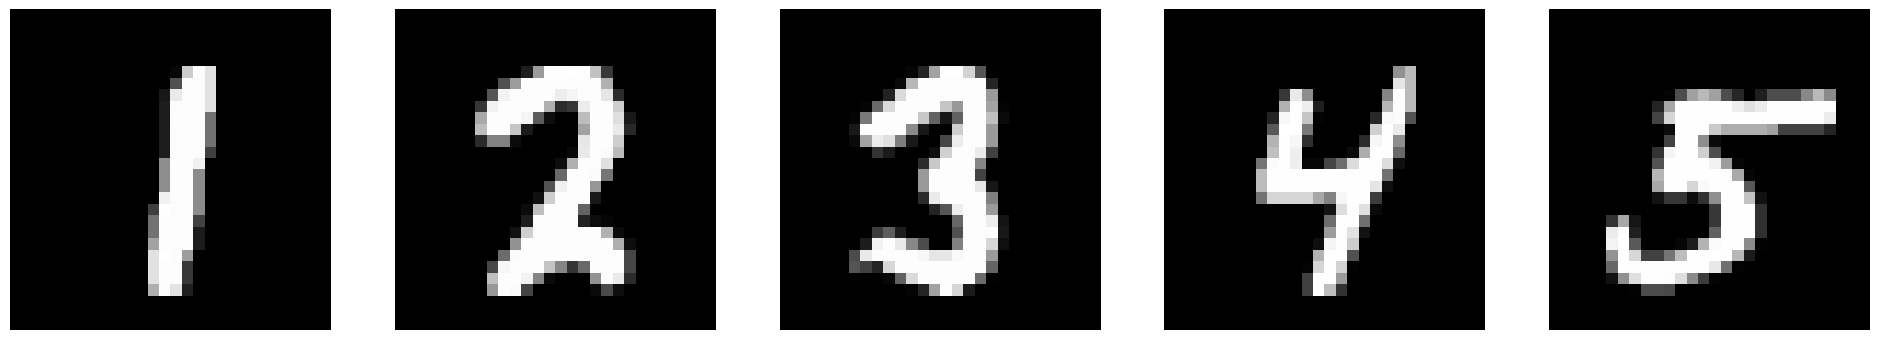

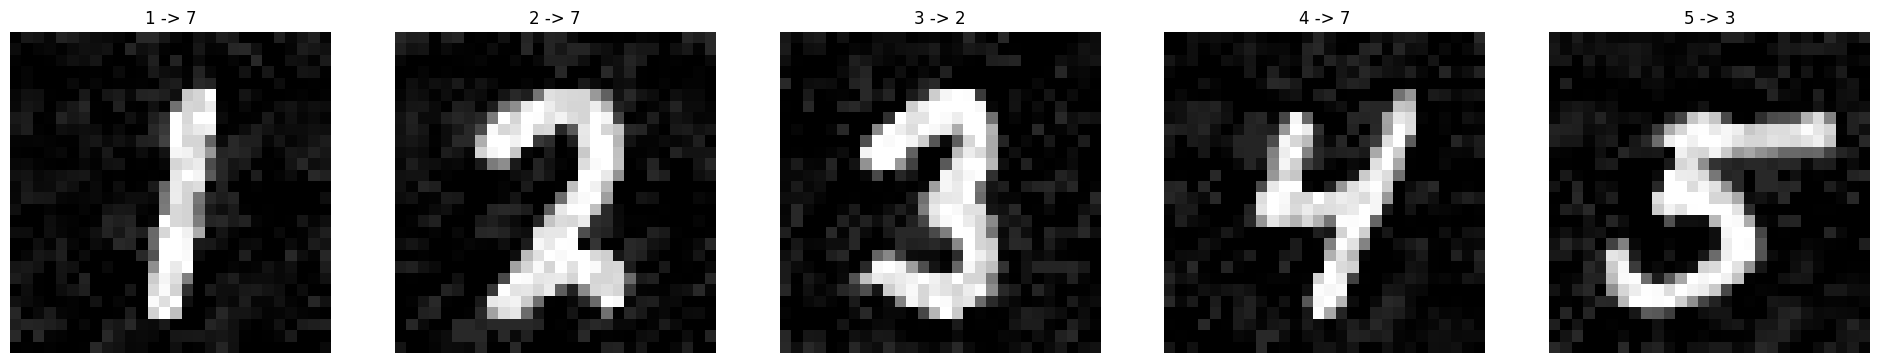

In [ ]:
model.eval()

correct = 0
total = 0
for images, labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()
    ae_images = pgd_attack(model, images, criterion,labels)

    outputs = model(ae_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the 10000 test images when PGD is used: {} %'.format((correct / total) * 100))


show_images(images[:5].detach())
show_images_withPred(ae_images[:5].detach(),labels[:5], outputs[:5].argmax(dim=1))